# Finetune SAM Model

**Dataset**

https://drive.google.com/drive/folders/1na6mkrFLiZZ6l0d4pKXqIsxAUxKhJDAu?usp=drive_link

In [1]:
# SAM model using
model_using = 'base'
# model_using = 'huge'

In [2]:
model_name = f'facebook/sam-vit-{model_using}'

In [ ]:
!accelerate test

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator(fp16=True)

In [20]:
import gdown
import os
import numpy as np
import tifffile
from random import randint
import matplotlib.pyplot as plt
import json
from pycocotools.coco import COCO

In [4]:
# Prepare the data
label_url = 'https://drive.google.com/file/d/1T8RDNBtxuBidm9ttNW9ShauDB49dBjWH/view?usp=drive_link'
train_url = 'https://drive.google.com/file/d/1De6cOV0UtS310-vkILWpmY7hiJZRSU9Y/view?usp=drive_link'
val_url = 'https://drive.google.com/file/d/1MFLm_5c0G6CUGNx2o2wrwGAKZHvUBCTI/view?usp=drive_link'
DVRPC_train_url = 'https://drive.google.com/file/d/1pHzGmjQUvrH1TY4XL1vw8xg72u8K5BuI/view?usp=drive_link'
DVRPC_val_url = 'https://drive.google.com/file/d/1YC5oUmGDa0sO14Qc4d-PM8cn2dbU1BKK/view?usp=drive_link'

In [5]:
# Download and unzip the files
data_path = os.path.join('..', 'data')
os.makedirs(data_path, exist_ok=True)
label_path = os.path.join(data_path, 'label.tar.gz')
train_path = os.path.join(data_path,'train.tar.gz')
val_path = os.path.join(data_path,'val.tar.gz')
DVRPC_train_path = os.path.join(data_path,'DVRPC_train.json')
DVRPC_val_path = os.path.join(data_path,'DVRPC_val.json')

train_path_new = os.path.join(data_path, 'Train')
if not os.path.exists(train_path_new):
    gdown.download(train_url, train_path, fuzzy=True)
    !tar -xzf {train_path} -C {data_path}
    !rm -rf {train_path}
train_path = train_path_new
label_path_new = os.path.join(data_path, 'Label')
if not os.path.exists(label_path_new):
    gdown.download(label_url, label_path, fuzzy=True)
    !tar -xzf {label_path} -C {data_path}
    # File too large, need to delete the file after unzipping
    !rm -rf {label_path} {os.path.join(label_path_new, 'Test2')}
label_path = label_path_new
val_path_new = os.path.join(data_path, 'Test')
if not os.path.exists(val_path_new):
    gdown.download(val_url, val_path, fuzzy=True)
    !tar -xzf {val_path} -C {data_path}
    !rm -rf {val_path}
val_path = val_path_new
if not os.path.exists(DVRPC_train_path):
    gdown.download(DVRPC_train_url, DVRPC_train_path, fuzzy=True)
if not os.path.exists(DVRPC_val_path):
    gdown.download(DVRPC_val_url, DVRPC_val_path, fuzzy=True)

train_label_path = os.path.join(label_path, 'Train')
val_label_path = os.path.join(label_path, 'Test')

In [6]:
train_files = [f for f in os.listdir(train_path) if (f.endswith('.tif') and np.max(tifffile.imread(os.path.join(train_label_path, f))) > 0)]
val_files = [f for f in os.listdir(val_path) if (f.endswith('.tif') and np.max(tifffile.imread(os.path.join(val_label_path, f))) > 0)]

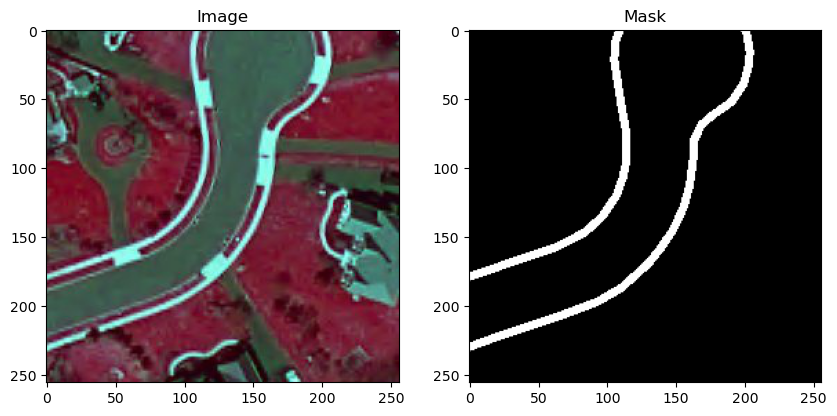

bboxes:  [[0, 0, 116, 182], [0, 0, 206, 233]]


In [8]:
# Visualize the data
%matplotlib inline
index = randint(0, len(train_files)-1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = tifffile.imread(os.path.join(train_path, train_files[index]))
label = tifffile.imread(os.path.join(train_label_path, train_files[index]))
ax[0].imshow(img)
ax[0].set_title('Image')
ax[1].imshow(label * 255, cmap='gray')
ax[1].set_title('Mask')

plt.show()

loading annotations into memory...
Done (t=2.02s)
creating index...
index created!


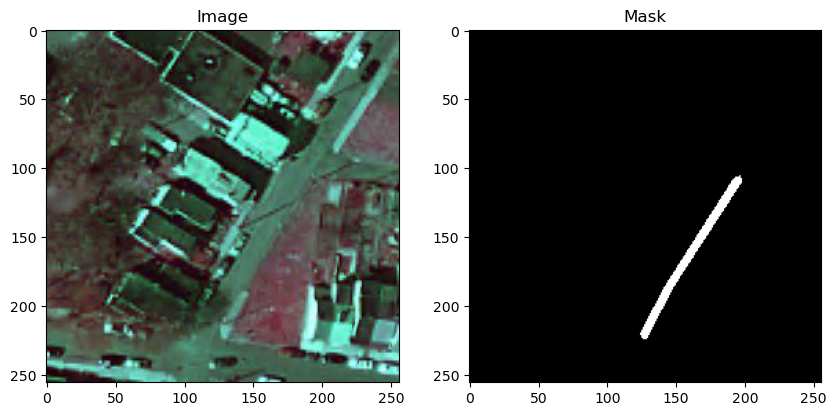

bbox: [124, 106, 198, 225]


In [23]:
# Visualize mask from annotation
train_coco = COCO(DVRPC_train_path)
ann_ids = train_coco.getAnnIds()
ann = train_coco.loadAnns(ann_ids[randint(0, len(ann_ids)-1)])[0]
img = tifffile.imread(os.path.join(train_path, train_coco.imgs[ann['image_id']]['file_name']))
mask = train_coco.annToMask(ann)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('Image')
ax[1].imshow(mask * 255, cmap='gray')
ax[1].set_title('Mask')

plt.show()

print(f'bbox: {ann["bbox"]}')

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import SamModel, SamProcessor
from torch.optim import Adam
from monai.losses import DiceLoss
from tqdm import tqdm
import statistics

In [10]:
device = accelerator.device

In [11]:
class SidewalkDatasetPlain(Dataset):
    def __init__(self, data_path: str, label_path: str, files: list, processor, transform=None):
        self.data_path = data_path
        self.label_path = label_path
        self.files = files
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img = tifffile.imread(os.path.join(self.data_path, self.files[idx]))
        label = tifffile.imread(os.path.join(self.label_path, self.files[idx]))
        if self.transform:
            img, label = self.transform(img, label)
        inputs = self.processor(img, return_tensors='pt')
        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs['labels'] = torch.tensor(label).unsqueeze(0)
        return inputs

class SidewalkDatasetBboxPrompt(Dataset):
    def __init__(self, data_path: str, coco_file: str, processor, transform=None):
        self.data_path = data_path
        self.label_path = label_path
        self.coco = COCO(coco_file)
        self.ann_ids = self.coco.getAnnIds()
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.ann_ids)
    
    def __getitem__(self, idx):
        ann = self.coco.loadAnns(self.ann_ids[idx])[0]
        img = tifffile.imread(os.path.join(self.data_path, self.coco.imgs[ann['image_id']]['file_name']))
        label = self.coco.annToMask(ann)
        bbox = ann['bbox']
        if self.transform:
            img, label = self.transform(img, label)
        inputs = self.processor(img, input_boxes=[[bbox]], return_tensors='pt')
        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs['labels'] = torch.tensor(label).unsqueeze(0)
        return inputs

In [12]:
# Load the processor and model
model_cache_dir = os.path.join('..', 'models')

sam_processor = SamProcessor.from_pretrained(model_name, cache_dir=model_cache_dir)
sam_model = SamModel.from_pretrained(model_name, cache_dir=model_cache_dir)

In [13]:
# Create datasets and dataloaders
train_dataset_plain = SidewalkDatasetPlain(train_path, train_label_path, train_files, sam_processor)
train_dataset_prompt = SidewalkDatasetBboxPrompt(train_path, DVRPC_train_path, sam_processor)
val_dataset_plain = SidewalkDatasetPlain(val_path, val_label_path, val_files, sam_processor)
val_dataset_prompt = SidewalkDatasetBboxPrompt(val_path, DVRPC_val_path, sam_processor)

train_dataloader_plain = DataLoader(train_dataset_plain, batch_size=4, shuffle=True)
train_dataloader_prompt = DataLoader(train_dataset_prompt, batch_size=4, shuffle=True)
val_dataloader_plain = DataLoader(val_dataset_plain, batch_size=4, shuffle=False)
val_dataloader_prompt = DataLoader(val_dataset_prompt, batch_size=4, shuffle=False)

In [14]:
# Show example of the dataset
sample = next(iter(train_dataloader_plain))
for k, v in sample.items():
    print(k, v.shape)

sample = next(iter(train_dataloader_prompt))
for k, v in sample.items():
    print(k, v.shape)

pixel_values torch.Size([4, 3, 1024, 1024])
original_sizes torch.Size([4, 2])
reshaped_input_sizes torch.Size([4, 2])
labels torch.Size([4, 1, 256, 256])


In [15]:
# Make sure we only compute gradients for mask decoder
for name, params in sam_model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        params.requires_grad = False

# Optimizer and loss function
optimizer = Adam(sam_model.parameters(), lr=1e-5)
loss_fn = DiceLoss(sigmoid=True, squared_pred=True)

In [ ]:
# Put the model and pytorch objects to accelerator
sam_model, optimizer, train_dataloader_plain, train_dataloader_prompt, val_dataloader_plain, val_dataloader_prompt = accelerator.prepare(
    sam_model, optimizer, train_dataloader_plain, train_dataloader_prompt, val_dataloader_plain, val_dataloader_prompt
)

In [ ]:
# Result path to save the model
result_path = os.path.join('..', 'models')
os.makedirs(result_path, exist_ok=True)

In [ ]:
# Training loop
num_epochs = 3

sam_model.to(device).train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader_plain):
        # Forward pass
        outputs = sam_model(pixel_values=batch['pixel_values'],
                            # input_boxes=batch['input_boxes'],
                            multimask_output=False)
        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch['labels'].float()
        loss = loss_fn(predicted_masks, ground_truth_masks)

        # Backward pass
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()
        epoch_losses.append(loss.item())

    print("Traing without prompt")
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {statistics.mean(epoch_losses)}')

    epoch_losses = []
    for batch in tqdm(train_dataloader_prompt):
        # Forward pass
        outputs = sam_model(pixel_values=batch['pixel_values'],
                            input_boxes=batch['input_boxes'],
                            multimask_output=False)
        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch['labels'].float()
        loss = loss_fn(predicted_masks, ground_truth_masks)

        # Backward pass
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()
        epoch_losses.append(loss.item())

    print("Traing with prompt")
    print(f'Epoch {epoch+1}, Loss: {statistics.mean(epoch_losses)}')

    # Save the model every epoch to avoid losing progress
    torch.save(sam_model.state_dict(), os.path.join(result_path, f'finetune_sam_{model_using}_epoch_{(epoch+1):03d}.pt'))

In [ ]:
# Save the model state dict
torch.save(sam_model.state_dict(), os.path.join(result_path, f'finetune_sam_{model_using}_model.pt'))

In [ ]:
# Evaluate the model
sam_model.eval()
val_losses = []
for batch in tqdm(val_dataloader_plain):
    with torch.no_grad():
        outputs = sam_model(pixel_values=batch['pixel_values'].to(device),
                            multimask_output=False)
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch['labels'].float().to(device)
        loss = loss_fn(predicted_masks, ground_truth_masks.unsqueeze(1))
        val_losses.append(loss.item())

print("Validation without prompt")
print(f'Validation Loss: {statistics.mean(val_losses)}')

val_losses = []
for batch in tqdm(val_dataloader_prompt):
    with torch.no_grad():
        outputs = sam_model(pixel_values=batch['pixel_values'].to(device),
                            input_boxes=batch['input_boxes'].to(device),
                            multimask_output=False)
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch['labels'].float().to(device)
        loss = loss_fn(predicted_masks, ground_truth_masks.unsqueeze(1))
        val_losses.append(loss.item())

print("Validation with prompt")
print(f'Validation Loss: {statistics.mean(val_losses)}')

In [ ]:
# Visualize the results
sample = next(iter(val_dataloader_plain))
with torch.no_grad():
    outputs = sam_model(pixel_values=sample['pixel_values'].to(device),
                        multimask_output=False)
    predicted_masks = outputs.pred_masks.squeeze(1)
    ground_truth_masks = sample['labels'].float().to(device)

%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample['pixel_values'][0].cpu().numpy())
ax[0].set_title('Image')
ax[1].imshow(predicted_masks[0].cpu().numpy(), cmap='gray')
ax[1].set_title('Predicted Mask')
ax[2].imshow(ground_truth_masks[0].cpu().numpy(), cmap='gray')
ax[2].set_title('Ground Truth Mask')

plt.show()